## Imports

In [1]:
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
import qiskit.quantum_info as qi
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram

import numpy as np
import math
import random

%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import cm

## Dataset generation

In [2]:
def create_savings(nr_of_queries, nr_of_plans):
    savings = {}
    nr_of_plans_each = int(nr_of_plans / nr_of_queries)
    for j in range(nr_of_plans):
        current_query = math.floor(j / nr_of_plans_each)
        first_plan_next_query = (current_query + 1) * nr_of_plans_each
        for i in range(first_plan_next_query, nr_of_plans):
            savings[j, i] = random.randint(-20, 0)

    return savings

In [3]:
n_problems = 500
problems = []

n_qubits = 4
n_plans = 2
n_queries = int(n_qubits/n_plans)

cost_min = 0
cost_max = 50


for i in range(n_problems):
    problems.append((n_queries, np.random.randint(cost_min, cost_max, n_qubits), create_savings(n_queries, n_qubits)))

In [6]:
problems[0:5]

[(2,
  array([ 9, 13, 15, 20]),
  {(0, 2): -14, (0, 3): -18, (1, 2): -9, (1, 3): -19}),
 (2,
  array([32, 34, 47,  1]),
  {(0, 2): -20, (0, 3): -18, (1, 2): -9, (1, 3): -6}),
 (2,
  array([16, 20,  6, 19]),
  {(0, 2): -12, (0, 3): -15, (1, 2): -5, (1, 3): -2}),
 (2,
  array([ 8, 38, 45, 45]),
  {(0, 2): -14, (0, 3): -15, (1, 2): -9, (1, 3): -9}),
 (2,
  array([11, 46, 34, 44]),
  {(0, 2): -2, (0, 3): -20, (1, 2): -8, (1, 3): -14})]

## Circuit design for ML approach

This function plots the bloch sphere

In [7]:
def plot_bloch_sphere(circuit):
    state = Statevector.from_instruction(circuit)
    display(plot_bloch_multivector(state))

Generate a scaler that calculates down the cost to a range of $\left[-\frac{\pi}{2},-\frac{\pi}{2}\right]$

In [4]:
def scale(features):
    scaler = MinMaxScaler((-np.pi/4,np.pi/4))
    return scaler.fit_transform(features)

To fit the scaler we need to extract all values out of the dataset.

In [5]:
def extract_values(dataset):
    values = []
    for row in dataset:
        values.append(
            np.concatenate((row[1].tolist(),list(row[2].values())))
            )
    return np.array(values)

As we do not know which combination of the plans leads to the optimal result, all plans have an equal probability of being taken. Therefor, we set all qubits to the state $|+\rangle$, which corresponds to $\frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle$

In [10]:
def probability_principle(circuit):
    circuit.h(range(circuit.width()))
    circuit.barrier()

Our plans have an innate cost to them, which have to be applied to each of them. 

In [6]:
def plan_costs(costs, circuit):
    for i, cost in enumerate(costs):
        circuit.ry(-cost, i)
    circuit.barrier()

The combination of plans leads to cost savings when executing them together. Therefor, we want to apply these savings onto the circuits. As we do not know, if CRY or CRZ is better, we will offer the possibility to do both.

In [7]:
def combination_savings(savings, circuit):
    for i, saves in enumerate(savings):
        circuit.crz(-saves[0], i, n_plans)
        circuit.crz(-saves[1], i, 1+n_plans)
    circuit.barrier()
    

Now we need to add the gates that have trainable parameters.

In [13]:
def trainable_weights(weights, circuit):
    for i, weight in enumerate(weights):
        circuit.rx(weight, i)
    circuit.barrier()

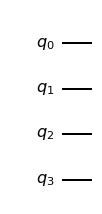

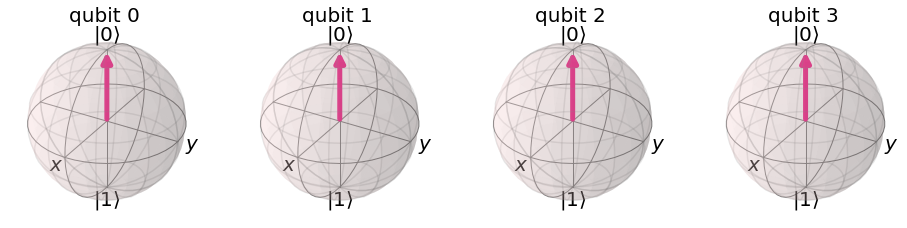

In [14]:
circuit = QuantumCircuit(n_qubits)
display(circuit.draw('mpl'))
plot_bloch_sphere(circuit)

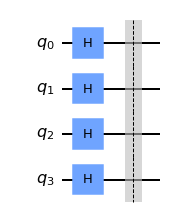

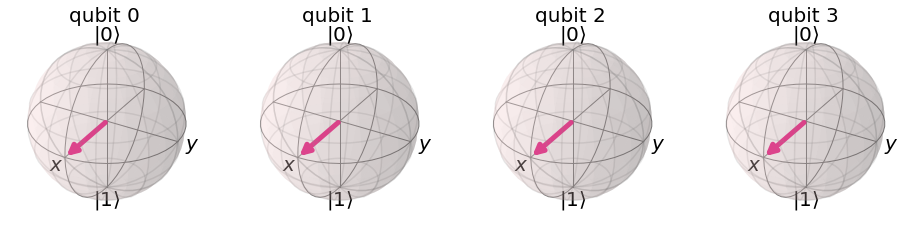

In [15]:
probability_principle(circuit)
display(circuit.draw('mpl'))
plot_bloch_sphere(circuit)

In [12]:
values = extract_values(problems)
t_values = scale(values[0].reshape(-1,1))


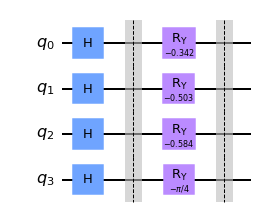

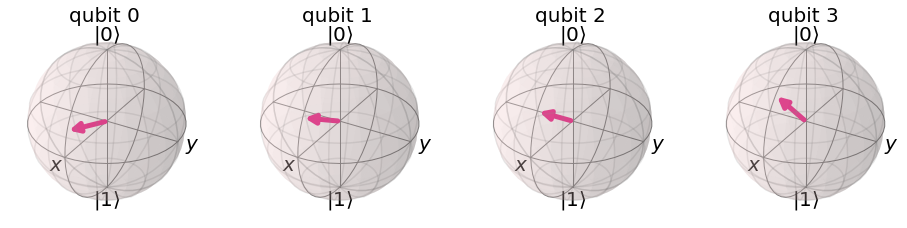

In [17]:
plan_costs(t_values[0:4].flatten(), circuit)
display(circuit.draw('mpl'))
plot_bloch_sphere(circuit)

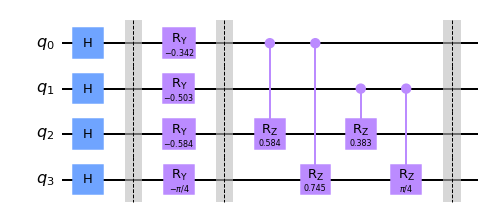

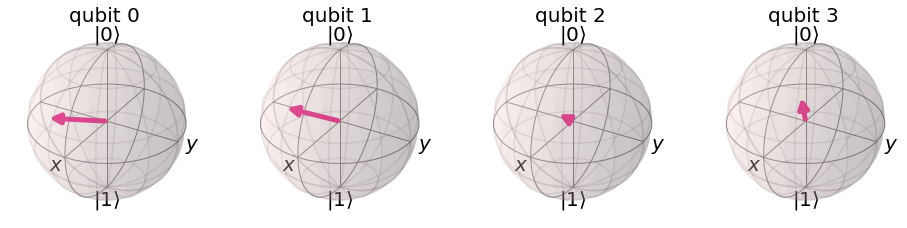

In [18]:
combination_savings(t_values[4:].reshape(n_plans,n_queries), circuit)
display(circuit.draw('mpl'))
plot_bloch_sphere(circuit)

Now we add max. weight connections between the plans for the same queries, so these dont get picked

In [19]:
def block_plans(circuit):
    circuit.crz(np.pi/4, 0,1)
    circuit.crz(np.pi/4, 2,3)

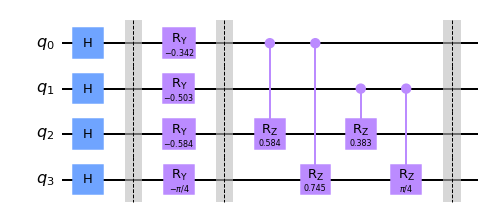

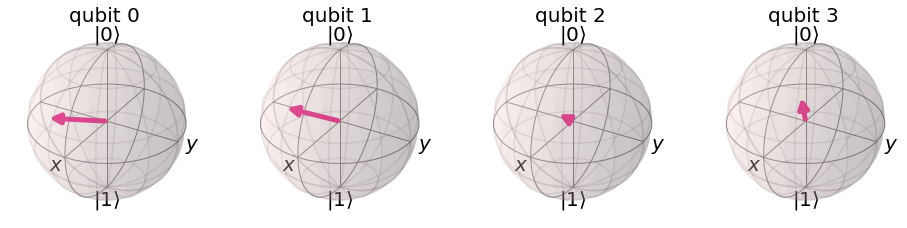

In [20]:
#block_plans(circuit)
display(circuit.draw('mpl'))
plot_bloch_sphere(circuit)

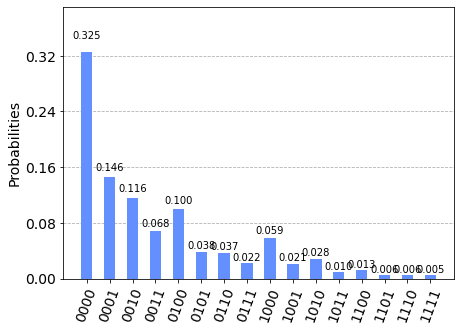

In [21]:
backend = Aer.get_backend('qasm_simulator')

circuit.measure_all()
job = backend.run(transpile(circuit, backend), shots=1024)

result = job.result()
counts=result.get_counts(circuit)
plot_histogram(counts)

In [22]:
problems[0]

(2,
 array([ 9, 13, 15, 20]),
 {(0, 2): -14, (0, 3): -18, (1, 2): -9, (1, 3): -19})

## Visualizing the dataset

In [13]:
n_values = []
for value in values:
    n_values.append(scale(value.reshape(-1,1)))

In [14]:
def to_plot_axes(values):
    x = []
    y = []
    z = []
    for entry in values:
        x.append(entry[0])
        y.append(entry[2])
        z.append(entry[0] + entry[2] + entry[n_qubits])
        
        x.append(entry[0])
        y.append(entry[3])
        z.append(entry[0] + entry[3] + entry[n_qubits])

        x.append(entry[1])
        y.append(entry[2])
        z.append(entry[1] + entry[2] + entry[n_qubits])

        
        x.append(entry[1])
        y.append(entry[3])
        z.append(entry[1] + entry[3] + entry[n_qubits])
    return x, y, z

In [15]:
x, y, z = to_plot_axes(values)
x_s, y_s, z_s = to_plot_axes(n_values)

Now we plot the normalized problems!

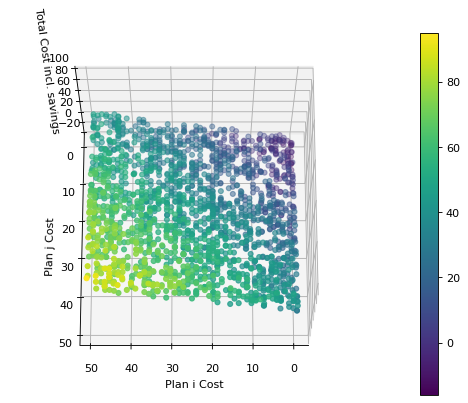

In [30]:
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(projection='3d')
plot = ax.scatter(x, y, z, c=z)
cb = plt.colorbar(plot, pad=0.1)
ax.set_xlabel('Plan i Cost')
ax.set_ylabel('Plan j Cost')
ax.set_zlabel('Total Cost incl. savings')
ax.view_init(azim=90, elev=70)
plt.show()

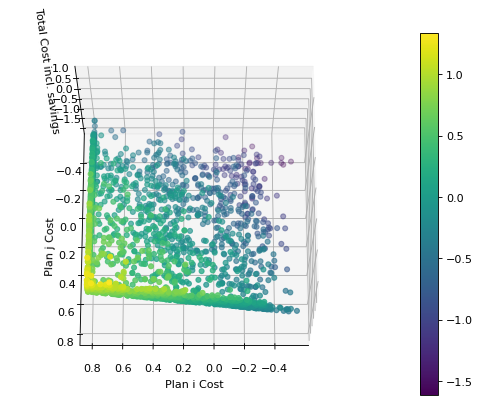

In [28]:
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(projection='3d')
plot = ax.scatter(x_s, y_s, z_s, c=z_s)
cb = plt.colorbar(plot, pad=0.1)
ax.set_xlabel('Plan i Cost')
ax.set_ylabel('Plan j Cost')
ax.set_zlabel('Total Cost incl. savings')
ax.view_init(azim=90, elev=70)
plt.show()

## Prepare for training!

In [29]:
params = []
#cost parameters
for i in range(n_plans*n_queries):
    params.append(Parameter('c_'+str(i)))

#savings parameters
for i in range(n_plans):
    params.append(Parameter('s_'+str(i)+str(n_plans)))
    params.append(Parameter('s_'+str(i)+str(n_plans+1)))
    
#trainable weight
#for i in range(n_qubits):
#    params.append(Parameter('w'+str(i)))
params.append(Parameter('w'))
params

[Parameter(c_0),
 Parameter(c_1),
 Parameter(c_2),
 Parameter(c_3),
 Parameter(s_02),
 Parameter(s_03),
 Parameter(s_12),
 Parameter(s_13),
 Parameter(w)]

As we want to try out a single trainable parameter, we need a new function to apply the gate

In [30]:
def trainable_weight(weight, circuit):
    for qubit in range(circuit.width()):
        circuit.rx(weight, qubit)

We now build the circuit and do training to evaluate our intuition

In [31]:

from qiskit import Aer, QuantumCircuit
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.algorithms.optimizers import COBYLA, ADAM, NELDER_MEAD, NFT, SLSQP, TNC, POWELL, L_BFGS_B
from qiskit.utils import QuantumInstance
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

/home/ricardo/miniconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We need to create $Y$ for the right solutions.

In [32]:
y = []
for problem in values:
    t_cost = np.array([])
    t_cost = np.append(t_cost, problem[0]+problem[2]+problem[4])
    t_cost = np.append(t_cost, problem[0]+problem[3]+problem[5])
    t_cost = np.append(t_cost, problem[1]+problem[2]+problem[6])
    t_cost = np.append(t_cost, problem[1]+problem[3]+problem[7])
    min = t_cost.argmin()
    if(min == 0):
        y.append(10)
    elif(min == 1):
        y.append(9)
    elif(min == 2):
        y.append(6)
    else:
        y.append(5)

In [33]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [34]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [35]:
x = np.array(n_values).reshape(150,8)

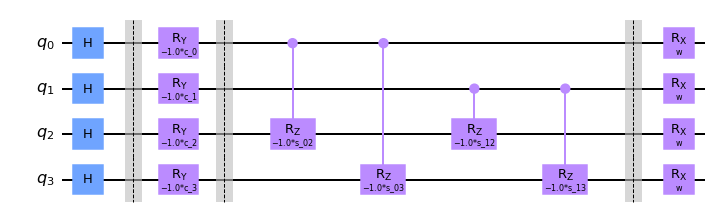

In [36]:
trainable_circuit = QuantumCircuit(n_queries*n_plans)
probability_principle(trainable_circuit)
plan_costs(params[0:4], trainable_circuit)
combination_savings(np.array(params[4:8]).reshape(2,2), trainable_circuit)
trainable_weight(weight=params[-1], circuit=trainable_circuit)
trainable_circuit.draw('mpl')

In [37]:
output_shape = 4
def parity(value):
    return value%4

# construct neural network classifier
qnn = CircuitQNN(
    circuit=trainable_circuit,
    input_params=trainable_circuit.parameters[0:8],
    weight_params=[trainable_circuit.parameters[-1]],
    quantum_instance=quantum_instance,
)

classifier = NeuralNetworkClassifier(
    neural_network=qnn, optimizer=COBYLA(), callback=callback_graph
)


x_train, x_test, y_train, y_test = train_test_split(np.array(x), np.array(y), test_size=1-3/4, random_state=69069)

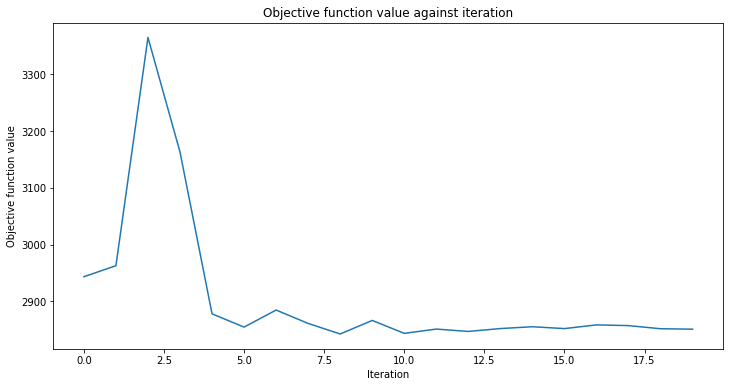

0.0

In [38]:

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
classifier.fit(x_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
classifier.score(x_test,  y_test)